In [36]:
%run DMD_functions.ipynb

**Umjetni primjer**

In [37]:
N=300
m=10
x=np.random.rand(N)
A=np.random.rand(N,N)
A = A/np.linalg.norm(A, 2)

In [38]:
X=np.empty((N,m+1))
X[:,0]=x
for i in range(m):
    X[:,i+1]=A@X[:,i]
X=X+np.random.rand(N,m+1)/N

In [39]:
Z, L = DMD(X[:,:m], X[:, 1:], N*np.finfo(float).resolution)

L

array([ 0.99881632+0.j        ,  0.51064872+0.55382316j,
        0.51064872-0.55382316j, -0.01221122+0.79435623j,
       -0.01221122-0.79435623j,  0.01178031+0.j        ,
       -0.0514574 +0.j        , -0.76877171+0.j        ,
       -0.57876293+0.50693336j, -0.57876293-0.50693336j])

In [40]:
#permutirani podaci - druge eigenvalues - kao što bi i očekivali!
print(X[:5,[1,6,8,9]])
temp=X[:,[1,6,8,9]]
X[:,[6,9]] = temp[:,[0,2]]
X[:,[1,8]] = temp[:,[1,3]]
print(X[:5,[1,6,8,9]])

Z_perm, L_perm = DMD(X[:,:m], X[:, 1:], N*np.finfo(float).resolution)

L_perm


[[0.52092473 0.51307292 0.51453174 0.51346164]
 [0.4976294  0.51118489 0.5079983  0.50933518]
 [0.44127451 0.44968537 0.44771245 0.44859854]
 [0.51499624 0.51101851 0.51042733 0.51095281]
 [0.49648348 0.49758749 0.49456994 0.49598254]]
[[0.51307292 0.52092473 0.51346164 0.51453174]
 [0.51118489 0.4976294  0.50933518 0.5079983 ]
 [0.44968537 0.44127451 0.44859854 0.44771245]
 [0.51101851 0.51499624 0.51095281 0.51042733]
 [0.49758749 0.49648348 0.49598254 0.49456994]]


array([ 9.98977858e-01+0.j        ,  6.33330976e-01+0.58645851j,
        6.33330976e-01-0.58645851j,  1.07922942e-01+0.82868091j,
        1.07922942e-01-0.82868091j,  5.37634963e-04+0.j        ,
       -6.87318369e-01+0.28171329j, -6.87318369e-01-0.28171329j,
       -4.55469208e-01+0.65770215j, -4.55469208e-01-0.65770215j])

In [41]:
Ze, Le = DMD_exact(X[:,:m], X[:, 1:], N*np.finfo(float).resolution)
Le
#isto kao L?

array([ 9.98977858e-01+0.j        ,  6.33330976e-01+0.58645851j,
        6.33330976e-01-0.58645851j,  1.07922942e-01+0.82868091j,
        1.07922942e-01-0.82868091j,  5.37634963e-04+0.j        ,
       -6.87318369e-01+0.28171329j, -6.87318369e-01-0.28171329j,
       -4.55469208e-01+0.65770215j, -4.55469208e-01-0.65770215j])

In [42]:
Zg, Lg, rg = GEDMD(X[:,:m], X[:,1:], N*np.finfo(float).resolution)
Lg

array([ 9.98977858e-01+0.j        ,  6.33330976e-01+0.58645851j,
        6.33330976e-01-0.58645851j,  1.07922942e-01+0.82868091j,
        1.07922942e-01-0.82868091j,  5.37634963e-04+0.j        ,
       -4.55469208e-01+0.65770215j, -4.55469208e-01-0.65770215j,
       -6.87318369e-01+0.28171329j, -6.87318369e-01-0.28171329j])

In [43]:
Z_qr, L_qr, r_qr, Q, R = GEDMDQ(X, N*np.finfo(float).resolution)
print(L_qr)

B = (A@X[:,m]+np.random.rand(N)/N).reshape((-1,1))

Z_added, L_added, r_added, _,_ = DMD_added_snap(B, Q, R, N*np.finfo(float).resolution)
print(L_added)

#provjera.. - dobije se isto
_,L_added_direct,_,_,_ = GEDMDQ(np.concatenate((X, B), axis=1), N*np.finfo(float).resolution)
print(L_added_direct)

print(np.allclose(L_added, L_added_direct))


[ 9.98977858e-01+0.j          6.33330976e-01+0.58645851j
  6.33330976e-01-0.58645851j  1.07922942e-01+0.82868091j
  1.07922942e-01-0.82868091j  5.37634963e-04+0.j
 -4.55469208e-01+0.65770215j -4.55469208e-01-0.65770215j
 -6.87318369e-01+0.28171329j -6.87318369e-01-0.28171329j]
[ 9.99517091e-01+0.j          6.75153831e-01+0.58272402j
  6.75153831e-01-0.58272402j  1.56970318e-01+0.71785015j
  1.56970318e-01-0.71785015j -9.05595948e-04+0.j
 -2.29017286e-01+0.71714833j -2.29017286e-01-0.71714833j
 -8.12105226e-01+0.j         -6.29998288e-01+0.449086j
 -6.29998288e-01-0.449086j  ]
[ 9.99517091e-01+0.j          6.75153831e-01+0.58272402j
  6.75153831e-01-0.58272402j  1.56970318e-01+0.71785015j
  1.56970318e-01-0.71785015j -9.05595948e-04+0.j
 -2.29017286e-01+0.71714833j -2.29017286e-01-0.71714833j
 -8.12105226e-01+0.j         -6.29998288e-01+0.449086j
 -6.29998288e-01-0.449086j  ]
True


In [44]:
Z_qr, L_qr, r_qr, Q, R = GEDMDQ(X, N*np.finfo(float).resolution)
print(L_qr)

l=2

Z_disc, L_disc, r_disc, _,_,_ = DMD_discarding_snap(l, Q, R, N*np.finfo(float).resolution)
print(L_added)

#provjera.. - dobije se isto
_,L_discarded_direct,_,_,_ = GEDMDQ(X[:,l:], N*np.finfo(float).resolution)
print(L_added_direct)

print(np.allclose(L_added, L_added_direct))

[ 9.98977858e-01+0.j          6.33330976e-01+0.58645851j
  6.33330976e-01-0.58645851j  1.07922942e-01+0.82868091j
  1.07922942e-01-0.82868091j  5.37634963e-04+0.j
 -4.55469208e-01+0.65770215j -4.55469208e-01-0.65770215j
 -6.87318369e-01+0.28171329j -6.87318369e-01-0.28171329j]
[ 9.99517091e-01+0.j          6.75153831e-01+0.58272402j
  6.75153831e-01-0.58272402j  1.56970318e-01+0.71785015j
  1.56970318e-01-0.71785015j -9.05595948e-04+0.j
 -2.29017286e-01+0.71714833j -2.29017286e-01-0.71714833j
 -8.12105226e-01+0.j         -6.29998288e-01+0.449086j
 -6.29998288e-01-0.449086j  ]
[ 9.99517091e-01+0.j          6.75153831e-01+0.58272402j
  6.75153831e-01-0.58272402j  1.56970318e-01+0.71785015j
  1.56970318e-01-0.71785015j -9.05595948e-04+0.j
 -2.29017286e-01+0.71714833j -2.29017286e-01-0.71714833j
 -8.12105226e-01+0.j         -6.29998288e-01+0.449086j
 -6.29998288e-01-0.449086j  ]
True


In [45]:
np.linalg.eigvals(A)[:10]

array([ 0.99879409+0.j        , -0.03480595+0.j        ,
        0.01193492+0.03161641j,  0.01193492-0.03161641j,
       -0.02316439+0.02428345j, -0.02316439-0.02428345j,
       -0.0302879 +0.01267351j, -0.0302879 -0.01267351j,
       -0.02072431+0.02559926j, -0.02072431-0.02559926j])

In [46]:
#!pip install pydmd

In [47]:
import pydmd
dmd1 = pydmd.DMD(svd_rank=10)
dmd1.fit(X[:,:m], X[:,1:])
dmd1.eigs

array([ 9.98977858e-01+0.j        ,  6.33330976e-01+0.58645851j,
        6.33330976e-01-0.58645851j,  1.07922942e-01+0.82868091j,
        1.07922942e-01-0.82868091j,  5.37634963e-04+0.j        ,
       -6.87318369e-01+0.28171329j, -6.87318369e-01-0.28171329j,
       -4.55469208e-01+0.65770215j, -4.55469208e-01-0.65770215j])

In [48]:
for i in range(dmd1.eigs.shape[0]):
    print(np.linalg.norm(dmd1.reconstructed_data[:,i]-X[:,i]))

7.255614009233213e-15
2.0060196783274847e-14
3.024248166384284e-14
4.724115121913534e-14
6.360787502075919e-14
7.435910670365584e-14
8.943975572796093e-14
1.040102114682448e-13
1.187906042922564e-13
1.3826690669507455e-13


In [49]:
dmd1.reconstructed_data.shape

(300, 10)

In [50]:
#usporedi s rezultatima lin regresije...

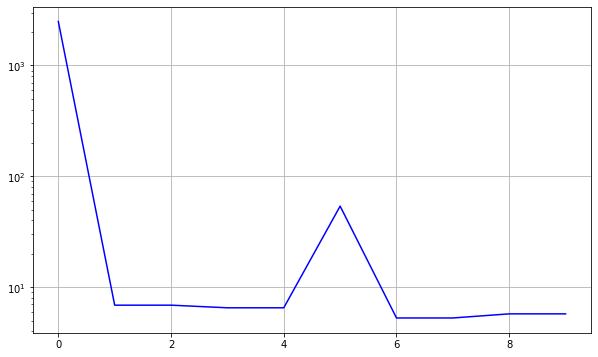

In [51]:
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(1/r_qr, marker='', linestyle='-', color='b')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

In [52]:
threshold=0 #uzimamo sve - ovo je mali primjer na kojem nema nikakve jednostavnije podstrukture
indices = np.where(1/r_qr > threshold)[0]
print(indices, indices.shape)

[0 1 2 3 4 5 6 7 8 9] (10,)


In [75]:
times=[j for j in range (X.shape[1])]
s = DMD_reconstruction(X[:,:m], Z_qr, indices, L_qr, times)
for i in range(m):
    print("norma razlike za trenutak {}:".format(i+1), np.linalg.norm(s[:,i]-X[:,i]))



norma razlike za trenutak 1: 3.167092879731096e-15
norma razlike za trenutak 2: 3.99872989463912e-15
norma razlike za trenutak 3: 4.678111493333719e-15
norma razlike za trenutak 4: 5.1034043367087296e-15
norma razlike za trenutak 5: 2.2134962793104323e-15
norma razlike za trenutak 6: 2.7633181220240483e-15
norma razlike za trenutak 7: 2.9136745176596057e-15
norma razlike za trenutak 8: 4.271473975239334e-15
norma razlike za trenutak 9: 2.738675149670302e-15
norma razlike za trenutak 10: 3.4808634655971465e-15


In [83]:
p=0.90
weights=[p**i for i in range (X.shape[1]-1)]
s = DMD_reconstruction(X[:,:m], Z_qr, indices, L_qr, times, weights)
for i in range(m):
    print("norma razlike za trenutak {}:".format(i+1), np.linalg.norm(s[:,i]-X[:,i]))

norma razlike za trenutak 1: 2.7918039794919095e-15
norma razlike za trenutak 2: 3.7735335743599086e-15
norma razlike za trenutak 3: 3.481748618431695e-15
norma razlike za trenutak 4: 3.8651071644422634e-15
norma razlike za trenutak 5: 2.7001482176858957e-15
norma razlike za trenutak 6: 3.5103945869613135e-15
norma razlike za trenutak 7: 2.786637675724875e-15
norma razlike za trenutak 8: 3.5230999567975442e-15
norma razlike za trenutak 9: 3.988699297339181e-15
norma razlike za trenutak 10: 4.786851168183692e-15


*proba za funkcije...*

In [37]:
#QR za (X Y) kad X i Y imaju "istu jezgru"
N=20; m=7
A = np.random.rand(N,N)
A=A/np.linalg.norm(A)
x = np.ones((N))
X=np.empty((N,m+1))
X[:,0] = x
for i in range(m):
    X[:,i+1]= A @ X[:,i]
#print(X)

Z = np.concatenate((X[:,:m], X[:,1:]), axis=1)
print(Z.shape)

Q, R = np.linalg.qr(Z, mode="reduced")

R_12 = R[:m,m:]
R_22 = R[m:2*m, m:]

Q_1 = Q[:,:m]
Q_2 = Q[:,m:]


print(np.allclose(X[:,1:],Q_1@R_12 + Q_2@R_22))
print(np.allclose(X[:,1:],Q_1@R_12 + Q_2*R_22[:,m-1]))
print(R_22)
print(R.shape)

(20, 14)
True
True
[[ 0. -0. -0.  0.  0. -0. -0.]
 [ 0. -0.  0. -0.  0.  0. -0.]
 [ 0.  0. -0.  0.  0. -0. -0.]
 [ 0.  0.  0.  0.  0. -0.  0.]
 [ 0.  0.  0.  0. -0.  0. -0.]
 [ 0.  0.  0.  0.  0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0. -0.]]
(14, 14)


In [38]:
"""HH transformacija - proba s kvadratnom matricom koja skoro gornje trokutasta (dvije sporedne diag ne-nula)"""
dim_trapez_m = 6

np.set_printoptions(precision=8, suppress=True)

trapez_m = np.random.rand(dim_trapez_m,dim_trapez_m)
trapez_m = np.triu(trapez_m, -2)
print(trapez_m)
trapez_copy = trapez_m.copy()
v_all=np.empty((3,dim_trapez_m-1))
#hh1 = np.eye(dim_trapez_m, dim_trapez_m)


#HH transf od R (trapezoidalna) 
#### racun od HH matrice ("Q") bi se mogao i ovdje dogoditi - primjena transformacija na I i onda uzmemo transponirano
for i in range(dim_trapez_m-2):
    element=trapez_m[i:(i+3),i]  
    v = element.copy().reshape(-1,1) #ako stavim v=element - pokazuju na istu memoriju; ne radi!!
    v[0] = v[0] + np.sign(element[0])*np.linalg.norm(element)
    trapez_m[i:(i+3),i:] = trapez_m[i:(i+3),i:] - 2/(v.T@v)*v@(v.T@trapez_m[i:(i+3),i:])
    #hh1[i:(i+3),i:] = hh1[i:(i+3),i:] - 2/(v.T@v)*v@(v.T@hh1[i:(i+3),i:])  #- daje krivo iz nekog razloga..
    #print("hh1",hh1,sep="\n")
    v_all[:,i] = v.reshape(-1)

#predzadnji stupac
element=trapez_m[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2]  
v = element.copy().reshape(-1,1)
v[0] = v[0] + np.sign(element[0])*np.linalg.norm(element)
trapez_m[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:] = trapez_m[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:] - 2/(v.T@v)*v@(v.T@trapez_m[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:])
#hh1[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:] = hh1[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:] - 2/(v.T@v)*v@(v.T@hh1[dim_trapez_m-2:dim_trapez_m,dim_trapez_m-2:])
v_all[:3,dim_trapez_m-2] = np.concatenate((v.reshape(-1),[0]), axis=0)

#print("hh1_fin",hh1.T, sep="\n")

##Q - from HH matrices
hh_current = np.eye(dim_trapez_m, dim_trapez_m)
v_current=v_all[:2,-1].reshape(-1,1)
hh_current[-2:,-2:] = np.eye(2,2)-2/(v_current.T@v_current)*(v_current@v_current.T)

hh=hh_current #ovdje @ I
#print(hh)

#print(v_all)
for i in range(dim_trapez_m-3,-1,-1):
    v_current = v_all[:,i].reshape(-1,1)
    hh_current = np.eye(3,3)-2/(v_current.T@v_current)*(v_current@v_current.T)
    hh[i:i+3, :] = hh_current@hh[i:i+3, :]
    #print(hh)
print("hh_pravi",hh, sep="\n")

print(trapez_m)
print(np.allclose(hh@trapez_m,trapez_copy))
np.set_printoptions()

[[0.90779766 0.24026112 0.63576259 0.78160247 0.99186843 0.87533124]
 [0.57628274 0.12775953 0.18682529 0.50859419 0.44976122 0.75803735]
 [0.1060759  0.39983493 0.42583291 0.44477279 0.93118969 0.99225576]
 [0.         0.39570073 0.96054955 0.56696481 0.61339007 0.29199759]
 [0.         0.         0.07208637 0.89094899 0.6106194  0.25574164]
 [0.         0.         0.         0.34073879 0.41367252 0.96694846]]
hh_pravi
[[-0.84017513 -0.03603672  0.24050622  0.07953852 -0.40514035 -0.25396609]
 [-0.53335501 -0.06847759 -0.2537924  -0.10901362  0.66995715  0.43093632]
 [-0.09817423  0.68042322 -0.67946445 -0.08844817 -0.1725112  -0.16772276]
 [ 0.          0.72872245  0.62247479  0.07627528  0.20399776  0.18454192]
 [ 0.          0.          0.16911348 -0.91283772  0.13760062 -0.34524484]
 [ 0.          0.          0.         -0.36725462 -0.54471054  0.75393267]]
[[-1.08048622 -0.30925609 -0.67560194 -0.97160944 -1.16464442 -1.23714849]
 [ 0.          0.54300609  0.95401648  0.65280002 

In [39]:
#test hh fje
N0=7; N=2
l=N0-N
trapez_m = np.random.rand(N0,N)
trapez_m = np.triu(trapez_m, -l)
trapez_copy=trapez_m.copy()
np.set_printoptions(precision=5, suppress=True)
print(trapez_m)

hh, R,_ = householder_for_dmd(trapez_m, l)
print(R)
print(np.allclose(hh@R, trapez_copy))

np.set_printoptions()

[[0.49639 0.2578 ]
 [0.06387 0.21872]
 [0.04459 0.80775]
 [0.55342 0.16883]
 [0.02724 0.48283]
 [0.12905 0.57114]
 [0.      0.97526]]
[[-0.75904 -0.47197]
 [-0.      -1.44325]
 [ 0.       0.     ]
 [ 0.       0.     ]
 [-0.       0.     ]
 [ 0.       0.     ]
 [ 0.      -0.     ]]
True
